## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [3]:
path = Path('./data/camvid-tiramisu')

In [5]:
path.ls()

[PosixPath('data/camvid-tiramisu/testannot'),
 PosixPath('data/camvid-tiramisu/test'),
 PosixPath('data/camvid-tiramisu/train'),
 PosixPath('data/camvid-tiramisu/valannot'),
 PosixPath('data/camvid-tiramisu/test.txt'),
 PosixPath('data/camvid-tiramisu/val'),
 PosixPath('data/camvid-tiramisu/val.txt'),
 PosixPath('data/camvid-tiramisu/trainannot'),
 PosixPath('data/camvid-tiramisu/train.txt')]

In [23]:
from fastai.utils import *
show_install()



```text
=== Software === 
python version  : 3.7.0
fastai version  : 1.0.30
torch version   : 1.0.0.dev20181120
nvidia driver   : 410.72
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7401
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform        : Linux-4.9.0-8-amd64-x86_64-with-debian-9.6
distro          : #1 SMP Debian 4.9.130-2 (2018-10-27)
conda env       : base
python          : /opt/anaconda3/bin/python
sys.path        : 
/home/jupyter/fastai-course-v3/nbs/dl1
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional packag

## Data

In [6]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('data/camvid-tiramisu/val/0016E5_08025.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_08091.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_08035.png')]

In [7]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('data/camvid-tiramisu/valannot/0016E5_08025.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_08091.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_08035.png')]

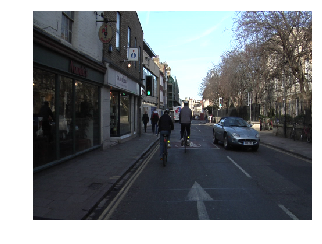

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

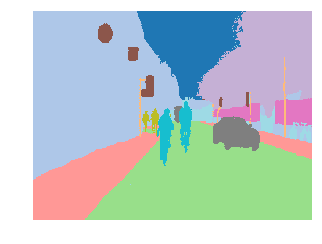

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          ...,
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3],
          [ 4,  4,  4,  ...,  3,  3,  3]]]))

## Datasets

In [12]:
bs,size = 8,src_size//2

In [13]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

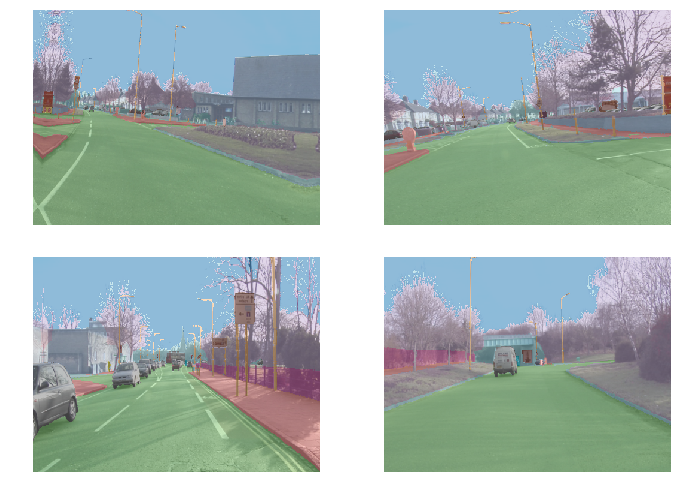

In [15]:
data.show_batch(2, figsize=(10,7))

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
metrics=acc_camvid
wd=1e-2

In [26]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


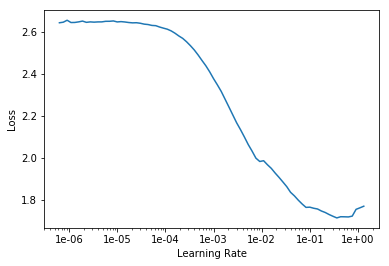

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr=1e-2

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.093660,0.926632,0.779257
2,0.736364,0.528229,0.866462
3,0.590955,1.281872,0.713994
4,0.511760,0.463571,0.871865
5,0.462905,0.634270,0.817917
6,0.449486,0.400320,0.886486
7,0.418488,0.358412,0.887084
8,0.392392,0.427267,0.883997
9,0.369077,0.394551,0.860053
10,0.332583,0.285030,0.914356


In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,0.273972,0.275924,0.921914
2,0.258078,0.303320,0.914446
3,0.259603,0.279492,0.922891
4,0.255300,0.274466,0.917818
5,0.271129,0.319125,0.905593
6,0.271587,0.337107,0.904645
7,0.278389,0.320809,0.912987
8,0.274049,0.273707,0.923933
9,0.272805,0.383789,0.893320
10,0.261363,0.238955,0.931650


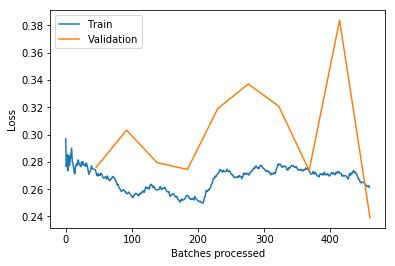

In [35]:
learn.recorder.plot_losses()

In [31]:
learn.save('stage-1')

In [32]:
learn.load('stage-1');

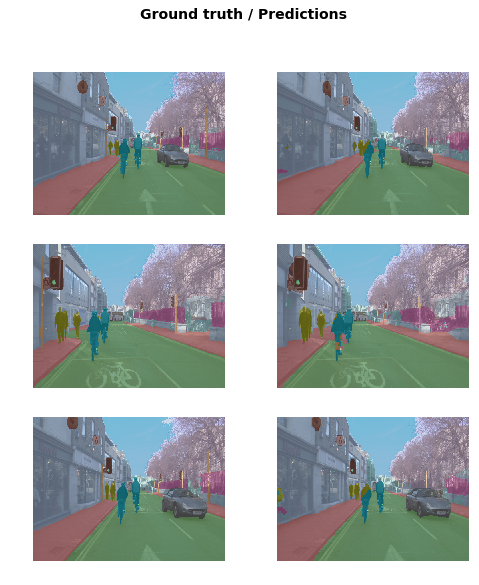

In [33]:
learn.show_results(rows=3, figsize=(8,9))

In [36]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


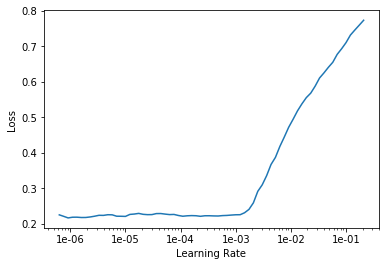

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lrs = slice(lr/400,lr/4)

In [39]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.217313,0.240561,0.932739
2,0.212404,0.246342,0.931198
3,0.209832,0.252450,0.928284
4,0.206371,0.247852,0.931943
5,0.199384,0.247701,0.933849
6,0.196781,0.265993,0.923722
7,0.210628,0.266706,0.922297
8,0.211703,0.247607,0.926736
9,0.204693,0.247057,0.930648
10,0.199650,0.245663,0.929006


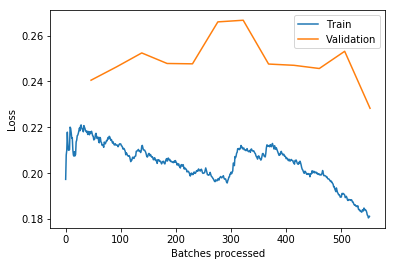

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [42]:
size = src_size
bs=8

In [43]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [44]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [45]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


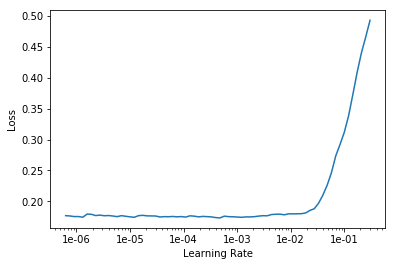

In [46]:
lr_find(learn)
learn.recorder.plot()

In [47]:
lr=3e-3

In [48]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.171826,0.230054,0.937986
2,0.178234,0.231999,0.937445
3,0.173336,0.237660,0.938208
4,0.176419,0.251091,0.934551
5,0.171710,0.244567,0.937229
6,0.175068,0.263360,0.934734
7,0.173408,0.263412,0.935284
8,0.171040,0.244970,0.936574
9,0.169149,0.240219,0.936683
10,0.161998,0.238797,0.938240


In [49]:
learn.save('stage-1-big')

In [50]:
learn.load('stage-1-big');

In [51]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


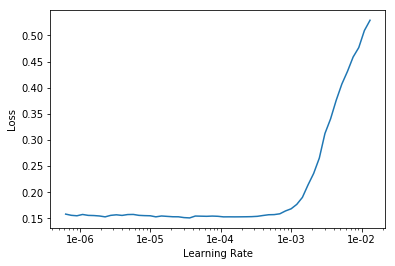

In [52]:
lr_find(learn)
learn.recorder.plot()

In [53]:
lrs = slice(lr/1000,lr/10)

In [54]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.153037,0.237703,0.938759
2,0.152531,0.240137,0.937994
3,0.151530,0.247255,0.937777
4,0.152128,0.240471,0.939328
5,0.151074,0.242815,0.938382
6,0.147786,0.242654,0.939135
7,0.147084,0.239942,0.939567
8,0.147213,0.240365,0.939256
9,0.146126,0.242531,0.938947
10,0.147120,0.240212,0.939595


In [55]:
learn.save('stage-2-big')

In [56]:
learn.load('stage-2-big')

Learner(data=ImageDataBunch;
Train: LabelList
y: SegmentationLabelList (367 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: data/camvid-tiramisu
x: SegmentationItemList (367 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: data/camvid-tiramisu;
Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480), ImageSegment (1, 360, 480)]...
Path: data/camvid-tiramisu
x: SegmentationItemList (101 items)
[Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480), Image (3, 360, 480)]...
Path: data/camvid-tiramisu;
Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, mom

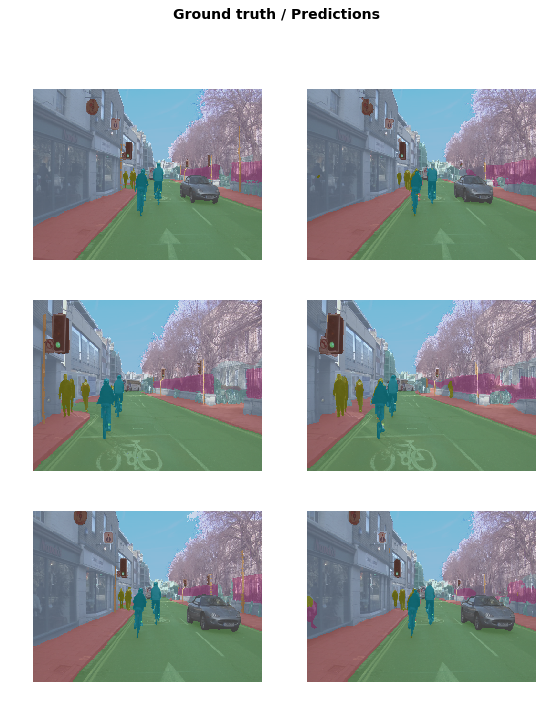

In [57]:
learn.show_results(rows=3, figsize=(9,11))

## fin